To use the OpenAI API, you'll need an API key. If you don't already have one, create a key in the OpenAI developer console.
In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `OPENAI_API_KEY`. Then pass the key to the SDK:

✅ Loaded 30 randomly sampled COPA examples
                                premise                     choice1  \
0  The man survived the deadly illness.         He signed his will.   
1        The bathroom sink was clogged.     I turned on the faucet.   
2            The check I wrote bounced.  My bank account was empty.   
3                 I lost track of time.          I was daydreaming.   
4         The boy sharpened the pencil.               It was cheap.   

                            choice2    answer  
0  He received an organ transplant.  choice 2  
1   I poured drain cleaner into it.  choice 2  
2             I earned a pay raise.  choice 1  
3                   I was nauseous.  choice 1  
4                      It was dull.  choice 2  

🚀 Running prompt: baseline


100%|██████████| 30/30 [00:10<00:00,  2.76it/s]



✅ baseline: 100.0% accuracy

🚀 Running prompt: 1-shot


100%|██████████| 30/30 [00:13<00:00,  2.19it/s]



✅ 1-shot: 100.0% accuracy

🚀 Running prompt: 3-shot


100%|██████████| 30/30 [00:27<00:00,  1.10it/s]



✅ 3-shot: 96.67% accuracy

🚀 Running prompt: 5-shot


100%|██████████| 30/30 [00:09<00:00,  3.20it/s]



✅ 5-shot: 100.0% accuracy

🚀 Running prompt: shuffled


100%|██████████| 30/30 [00:11<00:00,  2.68it/s]



✅ shuffled: 93.33% accuracy

🚀 Running prompt: mislabeled


100%|██████████| 30/30 [00:11<00:00,  2.67it/s]



✅ mislabeled: 90.0% accuracy

🚀 Running prompt: CoT


100%|██████████| 30/30 [01:58<00:00,  3.94s/it]


✅ CoT: 33.33% accuracy
💾 Saved: copa_summary_gpt-4o-mini.csv and copa_detailed_gpt-4o-mini.csv


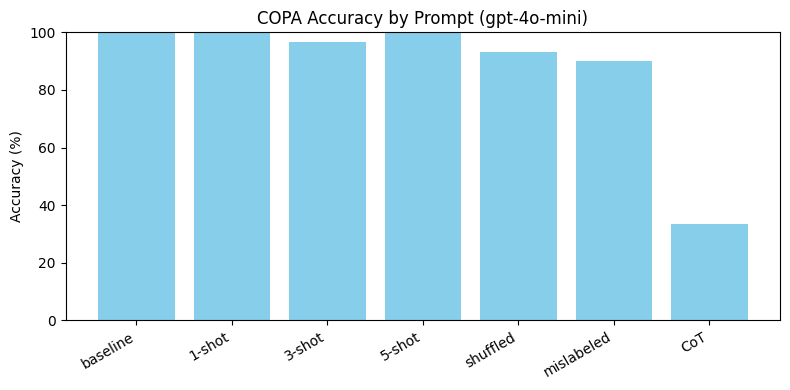


📊 Summary Results:
       Prompt  Accuracy
0    baseline    100.00
1      1-shot    100.00
2      3-shot     96.67
3      5-shot    100.00
4    shuffled     93.33
5  mislabeled     90.00
6         CoT     33.33


,prompt_name,premise,choice1,choice2,gold_answer,model_raw,model_parsed,correct
0,baseline,The man survived the deadly illness.,He signed his will.,He received an organ transplant.,choice2,choice 2,choice2,True
1,baseline,The bathroom sink was clogged.,I turned on the faucet.,I poured drain cleaner into it.,choice2,choice 2,choice2,True
2,baseline,The check I wrote bounced.,My bank account was empty.,I earned a pay raise.,choice1,choice 1,choice1,True
3,baseline,I lost track of time.,I was daydreaming.,I was nauseous.,choice1,choice 1,choice1,True
4,baseline,The boy sharpened the pencil.,It was cheap.,It was dull.,choice2,choice 2,choice2,True


In [48]:


!pip install openai datasets tqdm matplotlib pandas --quiet

import re
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from openai import OpenAI


from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get("OPEN_API_KEY")
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])


from datasets import load_dataset
import random

ds = load_dataset("pkavumba/balanced-copa", split="test")

# Randomly select 100 unique indices
random.seed(42)  # for reproducibility
indices = random.sample(range(len(ds)), 30)
ds_small = ds.select(indices)


df = ds_small.to_pandas()
df["answer"] = df["label"].apply(lambda x: "choice 1" if x == 0 else "choice 2")
df = df[["premise", "choice1", "choice2", "answer"]]

print(f"✅ Loaded {len(df)} randomly sampled COPA examples")
print(df.head())


instruction = (
    "You are a reasoning assistant. Choose which choice makes more sense as the cause "
    "or effect of the premise. Answer only with 'choice 1' or 'choice 2'."
)

prompts = {
    "baseline": instruction + "\n\nPremise: {premise}\nChoice 1: {c1}\nChoice 2: {c2}\nAnswer:",
    "1-shot": instruction + """
Example:
Premise: The girl made a wish.
Choice 1: She saw a black cat.
Choice 2: She saw a shooting star.
Answer: choice 2

Now solve:
Premise: {premise}
Choice 1: {c1}
Choice 2: {c2}
Answer:""",
    "3-shot": instruction + """
Example 1:
Premise: The girl made a wish.
Choice 1: She saw a black cat.
Choice 2: She saw a shooting star.
Answer: choice 2

Example 2:
Premise: The woman hired a lawyer.
Choice 1: She decided to sue her employer.
Choice 2: She decided to run for office.
Answer: choice 1

Example 3:
Premise: My car was towed.
Choice 1: I parked illegally.
Choice 2: I jumped the battery.
Answer: choice 1

Now solve:
Premise: {premise}
Choice 1: {c1}
Choice 2: {c2}
Answer:""",
    "5-shot": instruction + """
Example 1:
Premise: The woman waved.
Choice 1: The woman spotted her friend.
Choice 2: The woman ate her lunch.
Answer: choice 1

Example 2:
Premise: The girl made a wish.
Choice 1: She saw a black cat.
Choice 2: She saw a shooting star.
Answer: choice 2

Example 3:
Premise: The woman hired a lawyer.
Choice 1: She decided to sue her employer.
Choice 2: She decided to run for office.
Answer: choice 1

Example 4:
Premise: My car was towed.
Choice 1: I parked illegally.
Choice 2: I jumped the battery.
Answer: choice 1

Example 5:
Premise: The police closed the investigation.
Choice 1: The victim recovered.
Choice 2: They apprehended the suspect.
Answer: choice 2

Now solve:
Premise: {premise}
Choice 1: {c1}
Choice 2: {c2}
Answer:""",
    "shuffled": instruction + """
Example 1:
Premise: My car was towed.
Choice 1: I parked illegally.
Choice 2: I jumped the battery.
Answer: choice 1

Example 2:
Premise: The woman waved.
Choice 1: The woman spotted her friend.
Choice 2: The woman ate her lunch.
Answer: choice 1

Example 3:
Premise: The police closed the investigation.
Choice 1: The victim recovered.
Choice 2: They apprehended the suspect.
Answer: choice 2

Example 4:
Premise: The girl made a wish.
Choice 1: She saw a black cat.
Choice 2: She saw a shooting star.
Answer: choice 2

Example 5:
Premise: The woman hired a lawyer.
Choice 1: She decided to sue her employer.
Choice 2: She decided to run for office.
Answer: choice 1

Now solve:
Premise: {premise}
Choice 1: {c1}
Choice 2: {c2}
Answer:""",
    "mislabeled": instruction + """
Example 1:
Premise: The woman waved.
Choice 1: The woman spotted her friend.
Choice 2: The woman ate her lunch.
Answer: choice 2  # intentionally wrong

Example 2:
Premise: My car was towed.
Choice 1: I parked illegally.
Choice 2: I jumped the battery.
Answer: choice 2  # intentionally wrong

Now solve:
Premise: {premise}
Choice 1: {c1}
Choice 2: {c2}
Answer:""",

    "CoT": (
    "You are a reasoning assistant. For each question, first reason step by step "
    "why each choice could or could not make sense, and then give the best answer.\n\n"
    "Premise: {premise}\n"
    "Choice 1: {c1}\n"
    "Choice 2: {c2}\n"
    "Let's reason carefully:\n"
    "1️⃣ Consider both choices logically.\n"
    "2️⃣ Explain your reasoning.\n"
    "3️⃣ End with your final answer exactly as:\n"
    "Answer: choice 1\nor\nAnswer: choice 2"
)
}



def _enforce_answer_format(prompt_name: str, prompt_text: str) -> str:
    """Add explicit final answer cue for CoT and non-CoT prompts."""
    if prompt_name.lower() == "cot":
        return prompt_text + "\n\nAfter your reasoning, write a final line exactly as:\nAnswer: choice 1\nor\nAnswer: choice 2"
    else:
        return prompt_text + " (Reply strictly as 'choice 1' or 'choice 2')"

def parse_choice(raw_text: str):
    text = raw_text.strip().lower()
    if "choice 1" in text or "choice1" in text:
        return "choice1"
    if "choice 2" in text or "choice2" in text:
        return "choice2"
    m = re.search(r"\b([12])\b", text)
    if m:
        return f"choice{m.group(1)}"
    if "answer" in text:
        m = re.search(r"answer.*?([12])", text)
        if m:
            return f"choice{m.group(1)}"
    return None



def run_experiment_with_logging(model="gpt-4o-mini", save_csv=True, print_limit=5):
    all_rows = []
    summary = []

    for name, template in prompts.items():
        correct = 0
        print(f"\n🚀 Running prompt: {name}\n" + "="*80)

        for i, row in tqdm(df.iterrows(), total=len(df)):
            prompt_text = _enforce_answer_format(name, template.format(
                premise=row["premise"],
                c1=row["choice1"],
                c2=row["choice2"]
            ))

            try:
                resp = client.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": prompt_text}],
                    temperature=0
                )
                raw = resp.choices[0].message.content.strip()
            except Exception as e:
                raw = f"__ERROR__ {e}"

            pred = parse_choice(raw)
            gold = row["answer"].lower().replace(" ", "")
            is_correct = (pred == gold)
            if is_correct:
                correct += 1

            # if print_limit is None or i < print_limit:
            #     print(f"\n🧩 Example {i+1}")
            #     print(f"Premise: {row['premise']}")
            #     print(f"Choice 1: {row['choice1']}")
            #     print(f"Choice 2: {row['choice2']}")
            #     print(f"🔹 Model Raw Output:\n{raw}")
            #     print(f"🔎 Parsed Prediction: {pred}")
            #     print(f"✅ Correct Answer: {gold}")
            #     print("✔️ Correct" if is_correct else "❌ Incorrect")
            #     print("-" * 80)

            all_rows.append({
                "prompt_name": name,
                "premise": row["premise"],
                "choice1": row["choice1"],
                "choice2": row["choice2"],
                "gold_answer": gold,
                "model_raw": raw,
                "model_parsed": pred,
                "correct": is_correct
            })

        acc = round(100 * correct / len(df), 2)
        summary.append({"Prompt": name, "Accuracy": acc})
        print(f"\n✅ {name}: {acc}% accuracy\n" + "="*80)

    summary_df = pd.DataFrame(summary)
    detailed_df = pd.DataFrame(all_rows)

    if save_csv:
        summary_df.to_csv(f"copa_summary_{model}.csv", index=False)
        detailed_df.to_csv(f"copa_detailed_{model}.csv", index=False)
        print(f"💾 Saved: copa_summary_{model}.csv and copa_detailed_{model}.csv")

    plt.figure(figsize=(8, 4))
    plt.bar(summary_df["Prompt"], summary_df["Accuracy"], color="skyblue")
    plt.ylabel("Accuracy (%)")
    plt.title(f"COPA Accuracy by Prompt ({model})")
    plt.xticks(rotation=30, ha="right")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    return summary_df, detailed_df


summary_df, detailed_df = run_experiment_with_logging(
    model="gpt-4o-mini",
        print_limit=5  # print first 5 examples per prompt
)

print("\n📊 Summary Results:")
print(summary_df)
display(detailed_df.head())
